# Finance Analyzer — Step 4: Interactive Analysis

This notebook loads the enriched transactions CSV produced in Step 3 and performs exploratory analysis:

- Overall summary metrics
- Category breakdowns
- Merchant analysis (frequency & spend)
- Time-based patterns (month/week/day)
- SpendBucket distribution

Edit the `ENRICHED_CSV_PATH` variable below if your file is located elsewhere.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Path to enriched CSV (change if needed)
ENRICHED_CSV_PATH = Path('../data/phonepe_spendings_enriched.csv')
print('Enriched CSV path set to:', ENRICHED_CSV_PATH)
%matplotlib inline


Enriched CSV path set to: ..\data\phonepe_spendings_enriched.csv


In [4]:
if not ENRICHED_CSV_PATH.exists():
    raise FileNotFoundError(f'Enriched CSV not found: {ENRICHED_CSV_PATH}')

df = pd.read_csv(ENRICHED_CSV_PATH, parse_dates=['Date'])
print('Rows, columns:', df.shape)
df.head()


Rows, columns: (411, 12)


,Date,Merchant,Type,Amount,Month,Day,Day_Of_Week,Week_Number,SpendBucket,Category,Is_Weekend,Day_Type
0,2025-09-02,ASMITA MEDICAL,DEBIT,90.0,Sep-2025,2,Tuesday,36,Small,Other,False,Weekday
1,2025-09-02,More sweet and snacks,DEBIT,25.0,Sep-2025,2,Tuesday,36,Small,Food,False,Weekday
2,2025-09-02,Nagori Tea,DEBIT,20.0,Sep-2025,2,Tuesday,36,Small,Food,False,Weekday
3,2025-09-01,Nagori Tea,DEBIT,200.0,Sep-2025,1,Monday,36,Small,Food,False,Weekday
4,2025-09-01,Hotel Aswad,DEBIT,160.0,Sep-2025,1,Monday,36,Small,Food,False,Weekday


In [5]:
# Overall summary
summary = {}

if 'Type' in df.columns:
    debits = df[df['Type'].str.upper() == 'DEBIT']
    credits = df[df['Type'].str.upper() == 'CREDIT']
    summary['total_debit'] = debits['Amount'].sum()
    summary['total_credit'] = credits['Amount'].sum()
else:
    summary['total_debit'] = df['Amount'].sum()
    summary['total_credit'] = 0.0

summary['num_transactions'] = len(df)
summary['avg_transaction'] = df['Amount'].mean()
summary['median_transaction'] = df['Amount'].median()

pd.Series(summary)


total_debit           100791.000000
total_credit               0.000000
num_transactions         411.000000
avg_transaction          245.233577
median_transaction        31.000000
dtype: float64

In [6]:
# Category breakdown
cat = (
    df.groupby('Category', dropna=False)['Amount']
      .agg(total_amount='sum', tx_count='count')
      .sort_values('total_amount', ascending=False)
)
cat['pct_of_total'] = cat['total_amount'] / cat['total_amount'].sum() * 100
cat


,total_amount,tx_count,pct_of_total
Category,,,
Other,88837.0,204,88.139814
Food,11807.0,203,11.714340
Personal,85.0,2,0.084333
Transport,62.0,2,0.061513


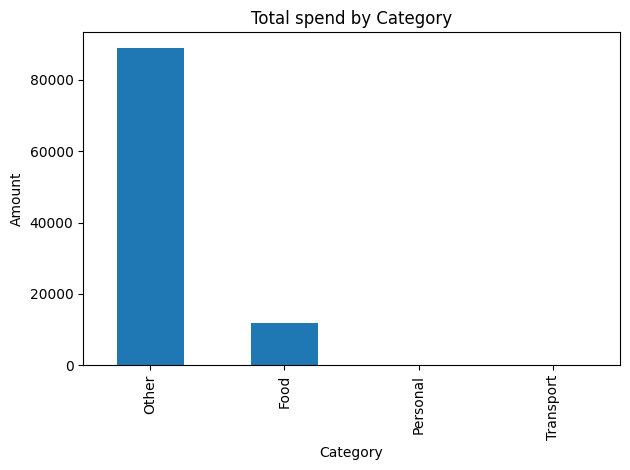

In [7]:
ax = cat['total_amount'].plot(kind='bar', title='Total spend by Category')
ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()


In [8]:
# Merchant analysis
merchant_stats = (
    df.groupby('Merchant', dropna=False)['Amount']
      .agg(total_amount='sum', tx_count='count')
)

merchant_top_freq = merchant_stats.sort_values('tx_count', ascending=False).head(15)
merchant_top_spend = merchant_stats.sort_values('total_amount', ascending=False).head(15)

merchant_top_freq, merchant_top_spend


(                              total_amount  tx_count
 Merchant                                            
 Nagori Tea                          2404.0       118
 RTG 2023                            3680.0        51
 More sweet and snacks                870.0        34
 NIROJINI RAJAN SILVERATANAM         1130.0        22
 Hotel Aswad                         1830.0        13
 ZOMATO                              1952.0        10
 CHETAK SWEET POINT GHANSOLI          970.0         9
 JAVED A CHOUDHARI                    140.0         7
 INSTANT RETAIL INDIA LIMITED         220.0         7
 Zomato private Limited              1321.0         7
 Zomato Online Order                 1143.0         6
 SHASHIKALA CHAUHAN                    44.0         4
 ZOMATO LIMITED                       865.0         4
 Cut And Care                         600.0         3
 ASMITA MEDICAL                       240.0         3,
                              total_amount  tx_count
 Merchant                   

In [9]:
# Time-based patterns
by_month = df.groupby('Month')['Amount'].sum().sort_index()
by_week = df.groupby('Week_Number')['Amount'].sum().sort_index()
by_dayofweek = df.groupby('Day_Of_Week')['Amount'].sum()

print('Spend by month:')
print(by_month)

print('\nSpend by ISO week number:')
print(by_week)

print('\nSpend by day of week:')
print(by_dayofweek)


Spend by month:
Month
Aug-2025    52217.0
Jul-2025    27144.0
Jun-2025    20923.0
Sep-2025      507.0
Name: Amount, dtype: float64

Spend by ISO week number:
Week_Number
23    15223.0
24     1667.0
25     1952.0
26     1852.0
27     2637.0
28    12104.0
29     2780.0
30     3265.0
31    27076.0
32    15656.0
33     1633.0
34    12257.0
35     2182.0
36      507.0
Name: Amount, dtype: float64

Spend by day of week:
Day_Of_Week
Friday       23223.0
Monday        5064.0
Saturday     13971.0
Sunday       13320.0
Thursday     17922.0
Tuesday      17974.0
Wednesday     9317.0
Name: Amount, dtype: float64


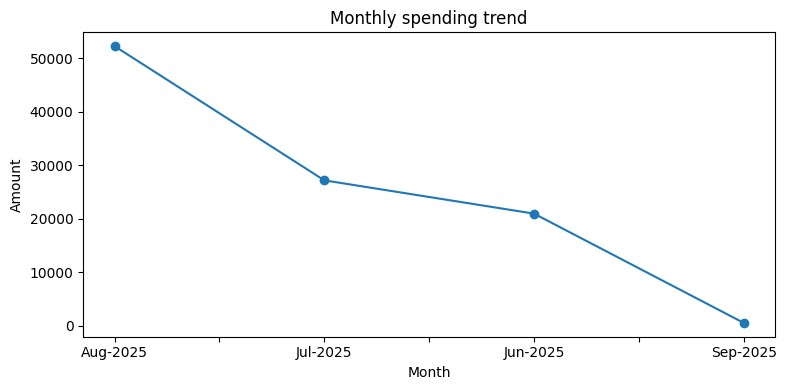

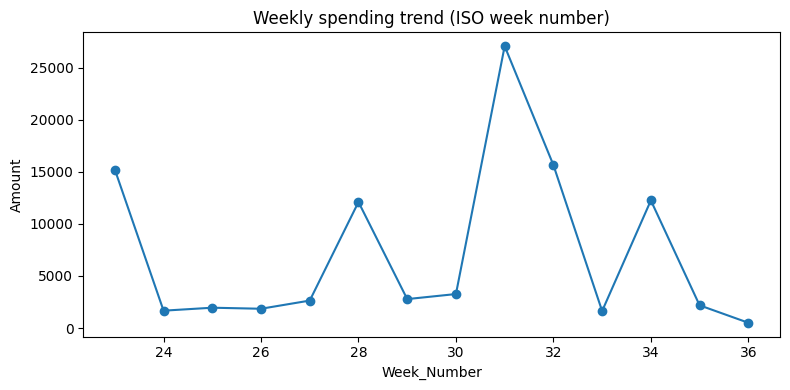

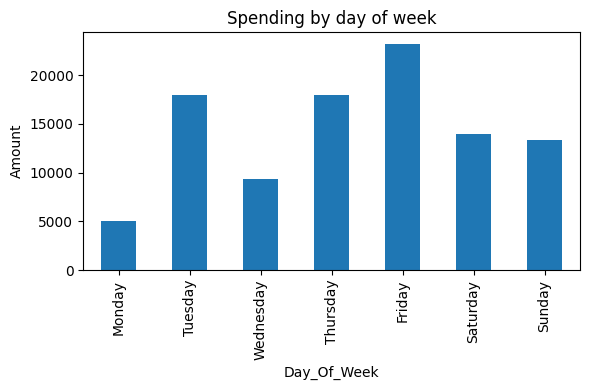

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
by_month.plot(ax=ax, marker='o', title='Monthly spending trend')
ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
by_week.plot(ax=ax, marker='o', title='Weekly spending trend (ISO week number)')
ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
by_dayofweek = by_dayofweek.reindex(weekday_order).fillna(0)
by_dayofweek.plot(kind='bar', ax=ax, title='Spending by day of week')
ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()


In [11]:
# SpendBucket distribution
bucket = df.groupby('SpendBucket')['Amount'].agg(total_amount='sum', tx_count='count')
bucket['pct_tx'] = bucket['tx_count'] / bucket['tx_count'].sum() * 100
bucket


,total_amount,tx_count,pct_tx
SpendBucket,,,
Large,72500.0,6,1.459854
Medium,2950.0,5,1.216545
Small,25341.0,400,97.323601


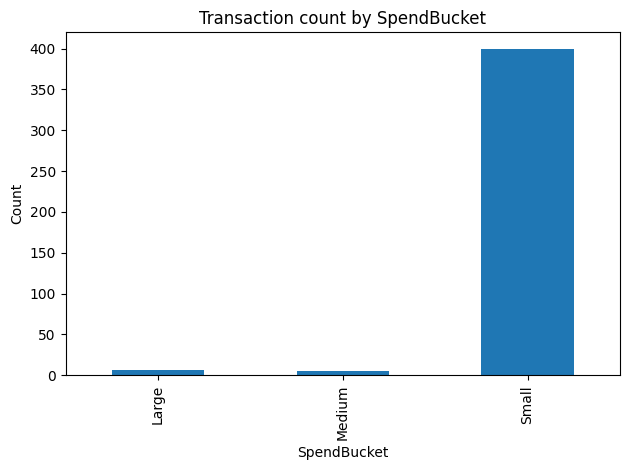

In [12]:
ax = bucket['tx_count'].plot(kind='bar', title='Transaction count by SpendBucket')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


In [13]:
# Save summary CSVs
out_dir = Path('data/analysis_summary')
out_dir.mkdir(parents=True, exist_ok=True)

cat.to_csv(out_dir / 'category_breakdown.csv')
merchant_stats.to_csv(out_dir / 'merchant_stats.csv')
by_month.to_csv(out_dir / 'spend_by_month.csv')
by_week.to_csv(out_dir / 'spend_by_week.csv')
bucket.to_csv(out_dir / 'spendbucket_summary.csv')

print('Saved summary CSVs to', out_dir)


Saved summary CSVs to data\analysis_summary


## Next steps

- Add rolling averages for weekly/monthly trends.
- Drill into top merchants (transaction-level view and sample rows).
- Build interactive visualizations (Plotly) or export charts for reports.

If you want, I can add additional analysis cells: anomaly detection, monthly budget comparison, or per-category time-series decomposition.